This guide shows a potential issue with the resonance generation keeping isomorphic and identical benzene structures.
This was generated using the `reactBenzenes` branch on Feb 16 2017.

In [2]:
from rmgpy.species import Species
from rmgpy.molecule import Molecule, Atom, Bond

In [2]:
benzene = Molecule().fromSMILES('c1ccccc1')
benzene.assignAtomIndices()
resStruc = benzene.generateResonanceIsomers(keepIsomorphic=True)

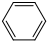

In [3]:
resStruc[0]

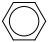

In [4]:
resStruc[1]

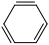

In [5]:
resStruc[2]

In [6]:
resStruc[0].isIsomorphic(resStruc[2])

True

In [7]:
resStruc[0].isIdentical(resStruc[2])

False

The previous line returns a non-deterministic result. I run it below 100 times and show the variation

In [8]:
benzene.generateResonanceIsomers(keepIsomorphic=True)

[Molecule(SMILES="C1=CC=CC=C1"),
 Molecule(SMILES="c1ccccc1"),
 Molecule(SMILES="C1=CC=CC=C1")]

In [10]:
isIdenticalList = []

for i in range(100):
    resStruc = benzene.generateResonanceIsomers(keepIsomorphic=True)
    identical = resStruc[0].isIdentical(resStruc[2])
    isIdenticalList.append(identical)
print 'The resonance structures are identical {} times'.format(isIdenticalList.count(True))
print 'The resonance structures are NOT identical {} times'.format(isIdenticalList.count(False))

The resonance structures are identical 54 times
The resonance structures are NOT identical 46 times


## look at whether I can get better symmetry when it's not identical
This is done on the `isotopeResonance` branch looking at resonance hybrids

In [3]:
benzene = Species().fromSMILES('c1ccccc1')

In [4]:
identical = True
i = 0
while i < 100 and identical:
    benzene = Species().fromSMILES('c1ccccc1')
    benzene.generateResonanceIsomers(keepIsomorphic=True)
    identical = benzene.molecule[0].isIdentical(benzene.molecule[2])
    i += 1
if i==100:
    raise Exception('The isomers were always identical')

In [5]:
identical

False

In [6]:
hybrid = benzene.getResonanceHybrid()
#print benzene.molecule[0].isIdentical(benzene.molecule[2])

for atom1 in hybrid.atoms:
    for atom2 in atom1.bonds.keys():
        bond = hybrid.getBond(atom1,atom2)
        print bond.getOrderNum()
        print bond.isBenzene()
        print bond.isOrder(1.5)

1.0
False
False
1.5
True
True
1.50000011921
True
True
1.0
False
False
1.50000011921
True
True
1.5
True
True
1.5
True
True
1.50000011921
True
True
1.0
False
False
1.50000011921
True
True
1.0
False
False
1.5
True
True
1.50000011921
True
True
1.0
False
False
1.5
True
True
1.5
True
True
1.0
False
False
1.50000011921
True
True
1.0
False
False
1.0
False
False
1.0
False
False
1.0
False
False
1.0
False
False
1.0
False
False


Proper structure is obtained. Possibly the error tolerance is too low, since these have 1.1e-7 error

In [7]:
hybrid.getSymmetryNumber()

12

In [8]:
hybrid

KeyError: 1.5000001192092896

KeyError: 1.5000001192092896

this rounding error still needs to be fixed.

## compare cyclic symmetry numbers explicitly

In [15]:
from rmgpy.molecule.symmetry import calculateCyclicSymmetryNumber

In [16]:
calculateCyclicSymmetryNumber(benzene.molecule[0])

3

In [17]:
# aromatic version
calculateCyclicSymmetryNumber(benzene.molecule[1])

12

In [18]:
calculateCyclicSymmetryNumber(hybrid)

12

## for aromatic benzene

In [19]:
molecule = benzene.molecule[1]

In [20]:
symmetryNumber = 1

rings = molecule.getSmallestSetOfSmallestRings()

# Get symmetry number for each ring in structure
for ring0 in rings:

    # Make another copy structure
    structure = molecule.copy(True)
    ring = [structure.atoms[molecule.atoms.index(atom)] for atom in ring0]

    # Remove bonds of ring from structure
    for i, atom1 in enumerate(ring):
        for atom2 in ring[i+1:]:
            if structure.hasBond(atom1, atom2):
                structure.removeBond(atom1.edges[atom2])

    structures = structure.split()
    groups = []
    for struct in structures:
        for atom in ring:
            if struct.hasAtom(atom): struct.removeAtom(atom)
        groups.append(struct.split())
    # Find equivalent functional groups on ring
    equivalentGroups = []; equivalentGroupCount = []
    for group in groups:
        found = False
        for i, eqGroup in enumerate(equivalentGroups):
            if not found and len(group) == len(eqGroup):
                for g, eg in zip(group, eqGroup):
                    if not g.isIsomorphic(eg):
                        # The groups do not match
                        break
                else:
                    # The groups match
                    found = True
            if found:
                # We've found a matching group, so increment its count
                equivalentGroupCount[i] += 1        
                break
        else:
            # No matching group found, so add it as a new group
            equivalentGroups.append(group)
            equivalentGroupCount.append(1)

    # Find equivalent bonds on ring
    equivalentBonds = []
    for i, atom1 in enumerate(ring0):
        for atom2 in ring0[i+1:]:
            if molecule.hasBond(atom1, atom2):
                bond = molecule.getBond(atom1, atom2)
                found = False
                for eqBond in equivalentBonds:
                    if not found:
                        if bond.equivalent(eqBond[0]):
                            eqBond.append(group)
                            found = True
                if not found:
                    equivalentBonds.append([bond])

    # Find maximum number of equivalent groups and bonds
    minEquivalentGroups = min(equivalentGroupCount)
    maxEquivalentGroups = max(equivalentGroupCount)
    minEquivalentBonds = None
    maxEquivalentBonds = 0
    for bonds in equivalentBonds:
        N = len(bonds)
        if minEquivalentBonds is None or N < minEquivalentBonds:
            minEquivalentBonds = N
        if N > maxEquivalentBonds:
            maxEquivalentBonds = N

    if maxEquivalentGroups == maxEquivalentBonds == len(ring):
        symmetryNumber *= len(ring) * 2
    else:
        symmetryNumber *= min(minEquivalentGroups, minEquivalentBonds)

In [21]:
maxEquivalentGroups

6

In [22]:
maxEquivalentBonds

6

## for hybrid structure

In [23]:
molecule = hybrid

In [24]:
symmetryNumber = 1

rings = molecule.getSmallestSetOfSmallestRings()

# Get symmetry number for each ring in structure
for ring0 in rings:

    # Make another copy structure
    structure = molecule.copy(True)
    ring = [structure.atoms[molecule.atoms.index(atom)] for atom in ring0]

    # Remove bonds of ring from structure
    for i, atom1 in enumerate(ring):
        for atom2 in ring[i+1:]:
            if structure.hasBond(atom1, atom2):
                structure.removeBond(atom1.edges[atom2])

    structures = structure.split()
    groups = []
    for struct in structures:
        for atom in ring:
            if struct.hasAtom(atom): struct.removeAtom(atom)
        groups.append(struct.split())
    # Find equivalent functional groups on ring
    equivalentGroups = []; equivalentGroupCount = []
    for group in groups:
        found = False
        for i, eqGroup in enumerate(equivalentGroups):
            if not found and len(group) == len(eqGroup):
                for g, eg in zip(group, eqGroup):
                    if not g.isIsomorphic(eg):
                        # The groups do not match
                        break
                else:
                    # The groups match
                    found = True
            if found:
                # We've found a matching group, so increment its count
                equivalentGroupCount[i] += 1        
                break
        else:
            # No matching group found, so add it as a new group
            equivalentGroups.append(group)
            equivalentGroupCount.append(1)

    # Find equivalent bonds on ring
    equivalentBonds = []
    for i, atom1 in enumerate(ring0):
        for atom2 in ring0[i+1:]:
            if molecule.hasBond(atom1, atom2):
                bond = molecule.getBond(atom1, atom2)
                found = False
                for eqBond in equivalentBonds:
                    if not found:
                        if bond.equivalent(eqBond[0]):
                            eqBond.append(group)
                            found = True
                if not found:
                    equivalentBonds.append([bond])

    # Find maximum number of equivalent groups and bonds
    minEquivalentGroups = min(equivalentGroupCount)
    maxEquivalentGroups = max(equivalentGroupCount)
    minEquivalentBonds = None
    maxEquivalentBonds = 0
    for bonds in equivalentBonds:
        N = len(bonds)
        if minEquivalentBonds is None or N < minEquivalentBonds:
            minEquivalentBonds = N
        if N > maxEquivalentBonds:
            maxEquivalentBonds = N

    if maxEquivalentGroups == maxEquivalentBonds == len(ring):
        symmetryNumber *= len(ring) * 2
    else:
        symmetryNumber *= min(minEquivalentGroups, minEquivalentBonds)

In [25]:
maxEquivalentGroups

6

In [26]:
maxEquivalentBonds

6

In [27]:
equivalentBonds

[[<Bond "1.5">,
  [Molecule(SMILES="[HH]", multiplicity=-187)],
  [Molecule(SMILES="[HH]", multiplicity=-187)],
  [Molecule(SMILES="[HH]", multiplicity=-187)],
  [Molecule(SMILES="[HH]", multiplicity=-187)],
  [Molecule(SMILES="[HH]", multiplicity=-187)]]]

In [28]:
equivalentBonds[0][0].equivalent(equivalentBonds[1][0])

IndexError: list index out of range

In [ ]:
equivalentBonds[0][0].isOrder(equivalentBonds[1][0].getOrderNum())

In [ ]:
# troublshooting equivalent
self = equivalentBonds[0][0]
other = equivalentBonds[1][0]

if isinstance(other, Bond):
    bond = other
    print (self.isOrder(bond.getOrderNum()))
elif isinstance(other, gr.GroupBond):
    bp = other
    print (any([self.isOrder(otherOrder) for otherOrder in bp.getOrderNum()]))

In [ ]:
# troublshooting equivalent
other = equivalentBonds[0][0]
self = equivalentBonds[1][0]

if isinstance(other, Bond):
    bond = other
    print (self.isOrder(bond.getOrderNum()))
elif isinstance(other, gr.GroupBond):
    bp = other
    print (any([self.isOrder(otherOrder) for otherOrder in bp.getOrderNum()]))

In [ ]:
def equivalent(self, other):
    """
    Return ``True`` if `other` is indistinguishable from this bond, or
    ``False`` otherwise. `other` can be either a :class:`Bond` or a
    :class:`GroupBond` object.
    """
    if isinstance(other, Bond):
        bond = other
        return (self.isOrder(bond.getOrderNum()))
    elif isinstance(other, gr.GroupBond):
        bp = other
        return any([self.isOrder(otherOrder) for otherOrder in bp.getOrderNum()])

In [ ]:
equivalent(self,other)

In [ ]:
self.equivalent(other)

something is wrong with how equivalent is functioning. I should get back to this tomorrow

## try the benzene structure except with allyl

In [11]:
from rmgpy.species import Species
from rmgpy.molecule import Molecule, Atom, Bond

In [12]:
benzene = Molecule().fromSMILES('C=C[CH2]')
benzene.assignAtomIndices()
resStruc = benzene.generateResonanceIsomers(keepIsomorphic=True)

In [13]:
resStruc[0]

In [14]:
resStruc[1]

In [33]:
resStruc[0].isIsomorphic(resStruc[1])

IndexError: list index out of range

In [34]:
resStruc[0].isIdentical(resStruc[1])

False

The previous line returns a non-deterministic result. I run it below 100 times and show the variation

In [35]:
isIdenticalList = []
for i in range(100):
    resStruc = benzene.generateResonanceIsomers(keepIsomorphic=True)
    identical = resStruc[0].isIdentical(resStruc[1])
    isIdenticalList.append(identical)
print 'The resonance structures are identical {} times'.format(isIdenticalList.count(True))
print 'The resonance structures are NOT identical {} times'.format(isIdenticalList.count(False))

The resonance structures are identical 0 times
The resonance structures are NOT identical 100 times


In [9]:
from IPython.display import display

In [16]:
for s in resStruc:
    display(s)